In [1]:
import blocksci
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.style as style
from matplotlib.widgets import TextBox
from matplotlib import rcParams
from matplotlib.offsetbox import AnchoredText
from datetime import datetime, timedelta
chain = blocksci.Blockchain("/home/ubuntu/bitcoin")

In [2]:
%time outputs_per_block = chain.map_blocks(lambda block: block.output_count)

CPU times: user 2.93 s, sys: 3.24 s, total: 6.17 s
Wall time: 3min 35s


In [3]:
%time miner_of_block = chain.map_blocks(lambda block: block.miner())

CPU times: user 11 s, sys: 0 ns, total: 11 s
Wall time: 28.2 s


Now I can create a dataframe and reduce it to only those where the output_count is one.

In [4]:
df = pd.DataFrame(data=outputs_per_block, columns=['output_count'])
df = df[df.output_count==1]
df["block_index"] =df.index
df = chain.heights_to_dates(df)

# Attribute the miner to each of these blocks.
df_miners = pd.DataFrame(miner_of_block, columns=["miner"])
df_miners["block_index"]=range(len(miner_of_block))

# Merge the datasets
df = pd.merge(df,df_miners , left_on="block_index", right_on="block_index", how="inner")
df = df.set_index("block_index")
df = chain.heights_to_dates(df)
df["time"]=df.index

# Lets group these into months so that I can more easily plot a histogram.
df_monthly = df.groupby([pd.Grouper(key="time", freq="M")]).output_count.count().reset_index()

# Filter from 2013 onwards
df_monthly = df_monthly[df_monthly.time>'2013']
df_monthly.columns = ["time", "frequency"]

Creating a chart

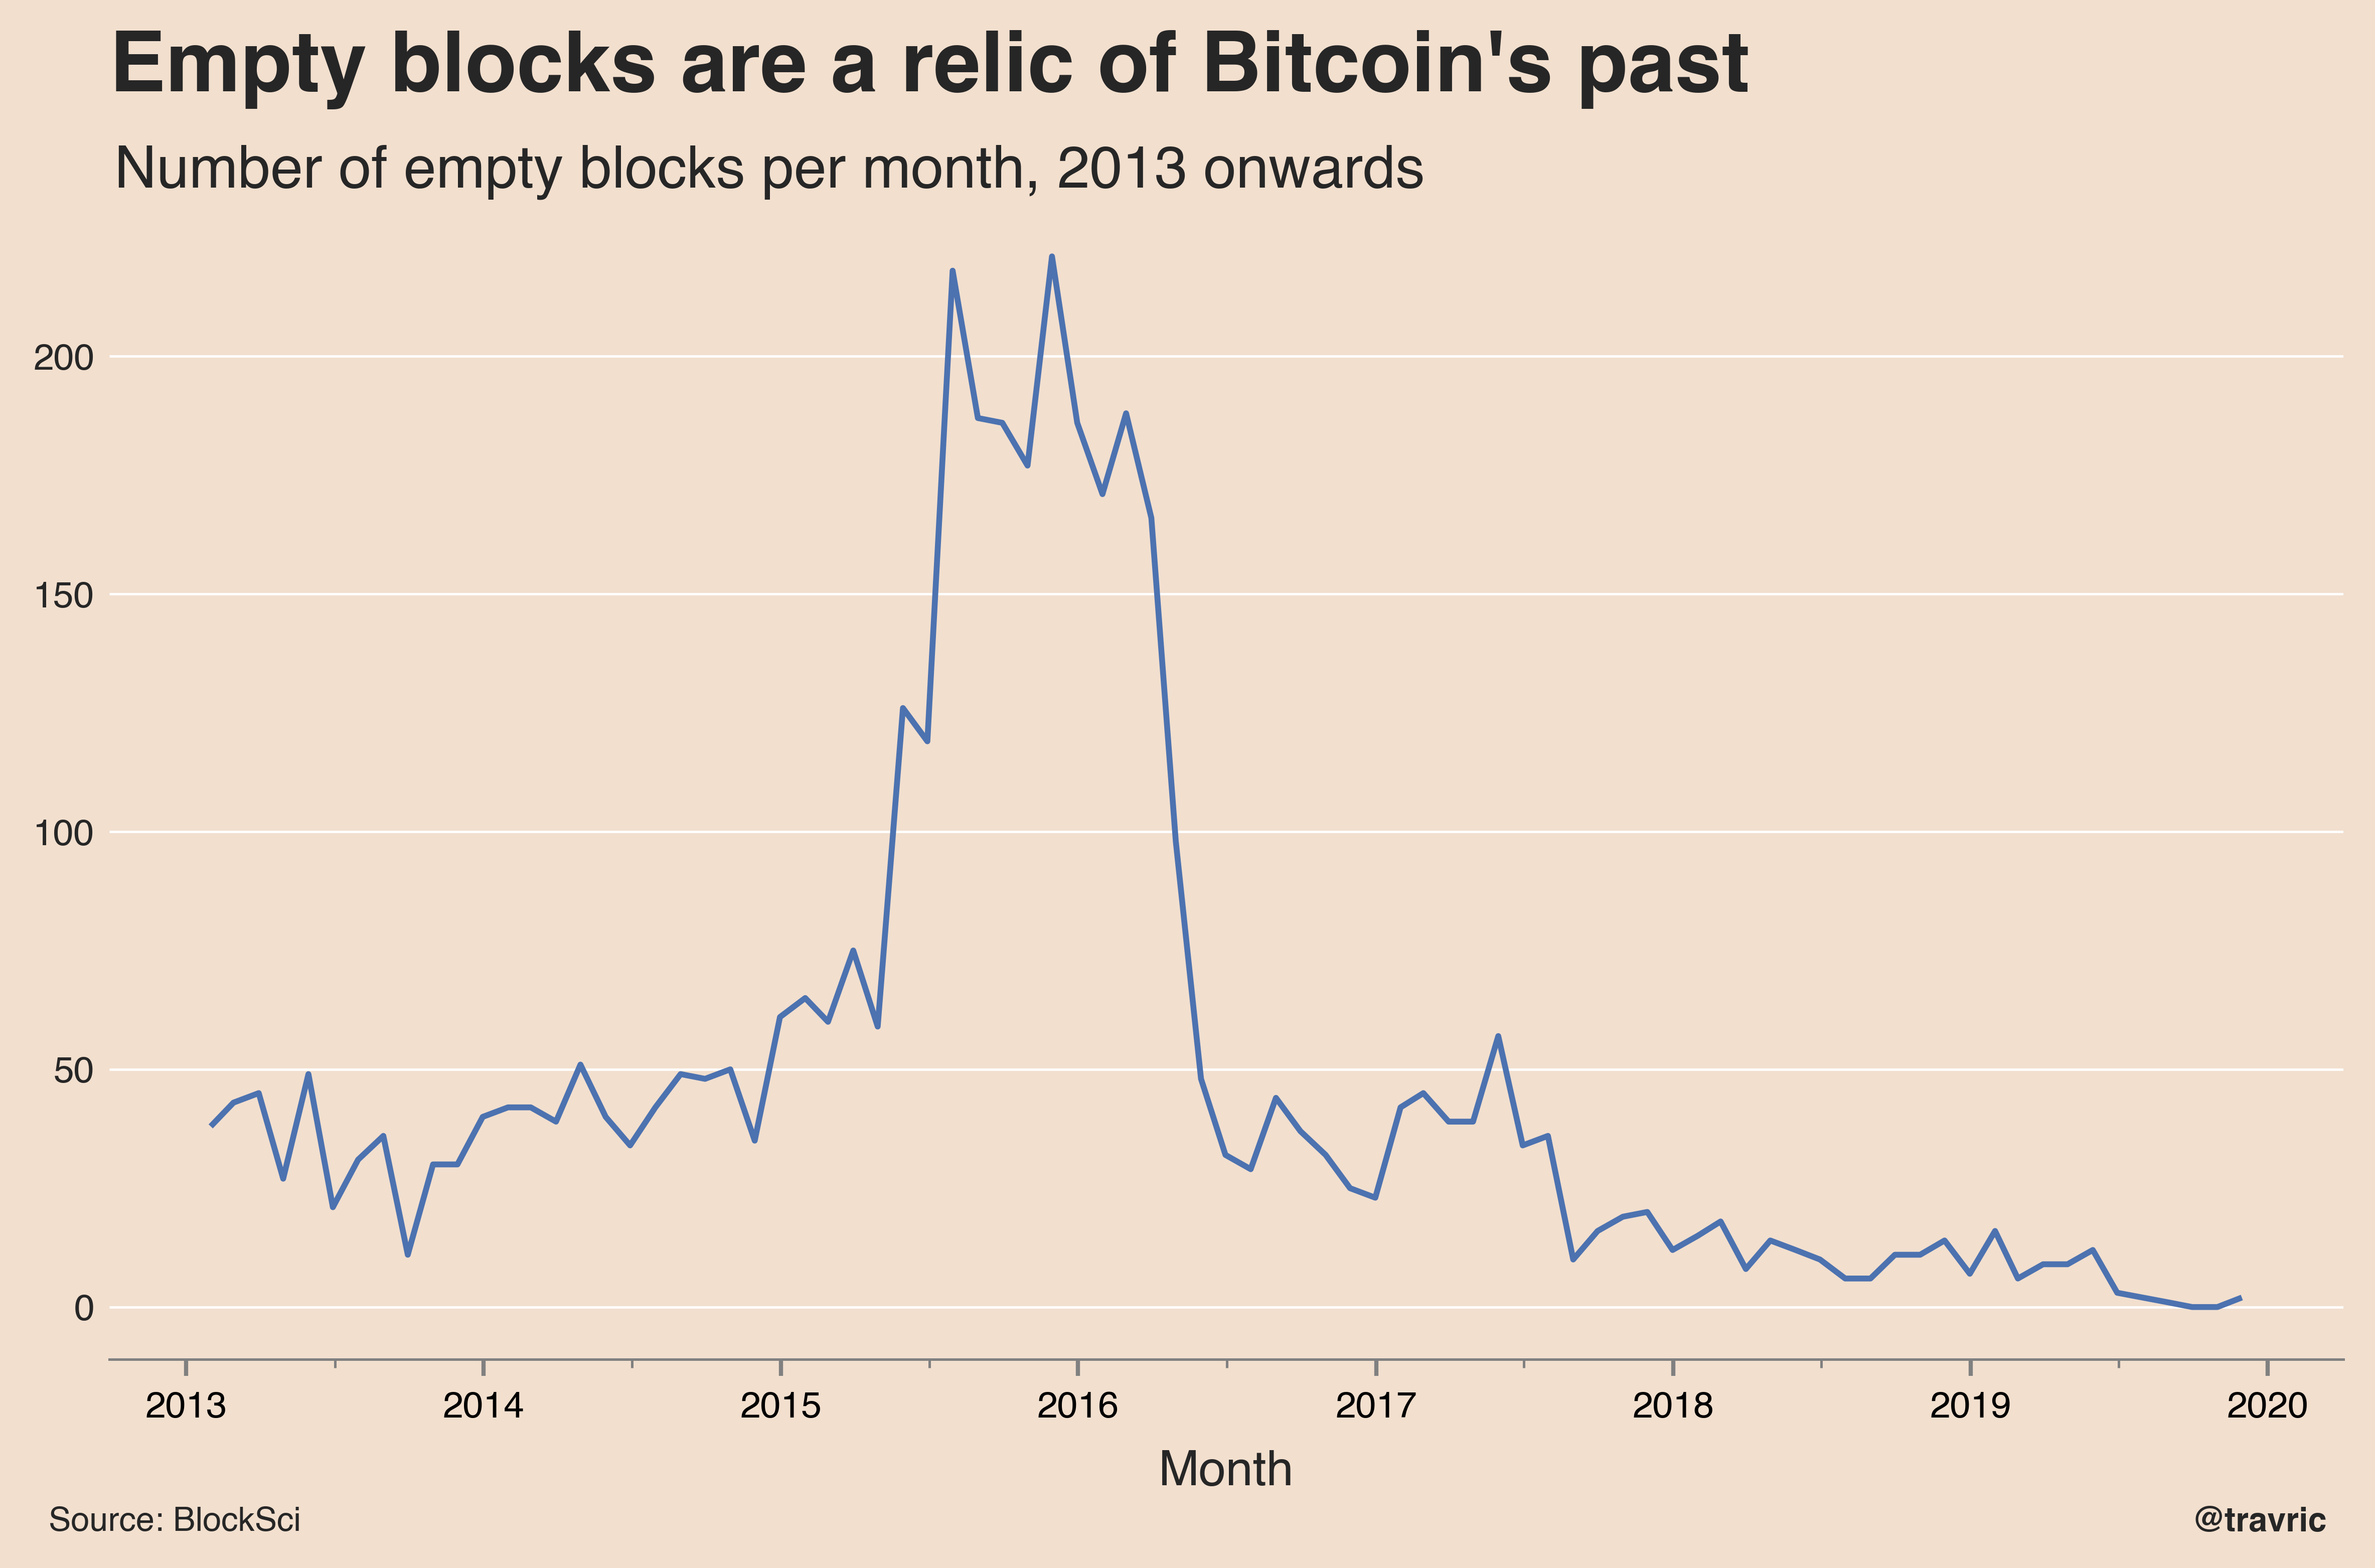

In [5]:
sns.set()   # Reset default params
sns.set(context ="paper")   # Enable efficient scaling of fonts. Choose from 'poster' , 'paper' 'talk'
style.use('fivethirtyeight')
sns.set_palette("deep")

# Choose the font family e.g sans-serif. Modify the family below
mpl.rcParams['font.sans-serif']=['Helvetica']
mpl.rc('font', family='sans-serif', stretch="semi-condensed" )
mpl.rc('axes', facecolor='#F2DFCE', edgecolor='grey', titlepad=27, labelpad=6, labelsize='small', linewidth=0.6, titleweight="bold")
mpl.rc('lines', linewidth=1.4, linestyle='-')
mpl.rc('patch', force_edgecolor=True, linewidth=0)
mpl.rc('xtick.major', size=4, width=1 )
mpl.rc('xtick.minor', size=2, width=0.6,  visible=True)
mpl.rc('xtick', bottom=True, color="grey")
mpl.rc('axes.spines', right=False, top=False, left=False)
mpl.rcParams['axes.grid.axis'] = 'y'
mpl.rc('grid', color="white", linewidth=0.57)
mpl.rc('figure', figsize=(8.5333,4.8), facecolor='#F2DFCE' , dpi=600, titleweight='light', titlesize='medium')


# Creating my figure and setting up first sublot within the figure
fig, ax1 = plt.subplots()
plt.subplots_adjust(bottom=0.11, top=0.91)


# Plotting the line via OOP method
ax1.plot(df_monthly.time, df_monthly["frequency"])
ax1.set_xlabel("Month")
ax1.set_title("Empty blocks are a relic of Bitcoin's past", loc="left")
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
plt.suptitle("Number of empty blocks per month, 2013 onwards", ha='left', va='bottom', x=0.082, y=0.913)
plt.setp(ax1.get_xticklabels(), color="black")

# Adding the caption at the bottom (which is its own subplot in the figure, appended below the first)
axbox = plt.axes([0.05, 0, 0.9, 0.02], yticklabels=[], xticklabels=[], xticks=[], frame_on=False)
axbox.grid(False)
axbox.add_artist(AnchoredText("@travric", frameon=False, loc="upper right", pad=0, prop=dict(fontsize="8", fontweight="bold")))
axbox.add_artist(AnchoredText("Source: BlockSci", frameon=False, loc="upper left", pad=0, prop=dict(fontsize="8")))
plt.show()

We should ask, which miners are the largest contributors to producing empty blocks?

In [6]:
# Grouping by month and miner
df2 = df.groupby([pd.Grouper(key="time", freq="M"), pd.Grouper(key="miner")]).output_count.count().reset_index()

# Let's filter from 2013 onwards for relevancy
df2 = df2[df2.time>'2013']
df2 = df2.pivot(index="time", columns="miner", values="output_count").reset_index()

Lets group some of these terms together for simplicity

In [7]:
# Group the long tail of small pools together by first making a list of them
sorted_df2 = pd.DataFrame(df2.sum().sort_values(ascending=False)).reset_index()
list_miner_tail=[]
for i in sorted_df2.index:
    if i > 9:
        list_miner_tail.append(sorted_df2.iloc[i]["miner"])
df2["Other"]= df2[list_miner_tail].sum(axis=1)

# Group Bitmain's two pools together
df2["Antpool or BTC.com"] = df2[["AntPool","BTC.com"]].sum(axis=1)

In [8]:
# Now to avoid duplication, refine columns
list_miner_top = ["Antpool or BTC.com"]
for i in sorted_df2.index:
    if (sorted_df2.iloc[i]['miner'] not in ["AntPool", "BTC.com"]) and (i<=9):
        list_miner_top.append(sorted_df2.iloc[i]["miner"])
list_miner_top.append("Other")

df2 = df2[["time"]+list_miner_top].fillna(0)
df2 = df2.set_index(df2.time, drop=True).drop('time', axis=1)

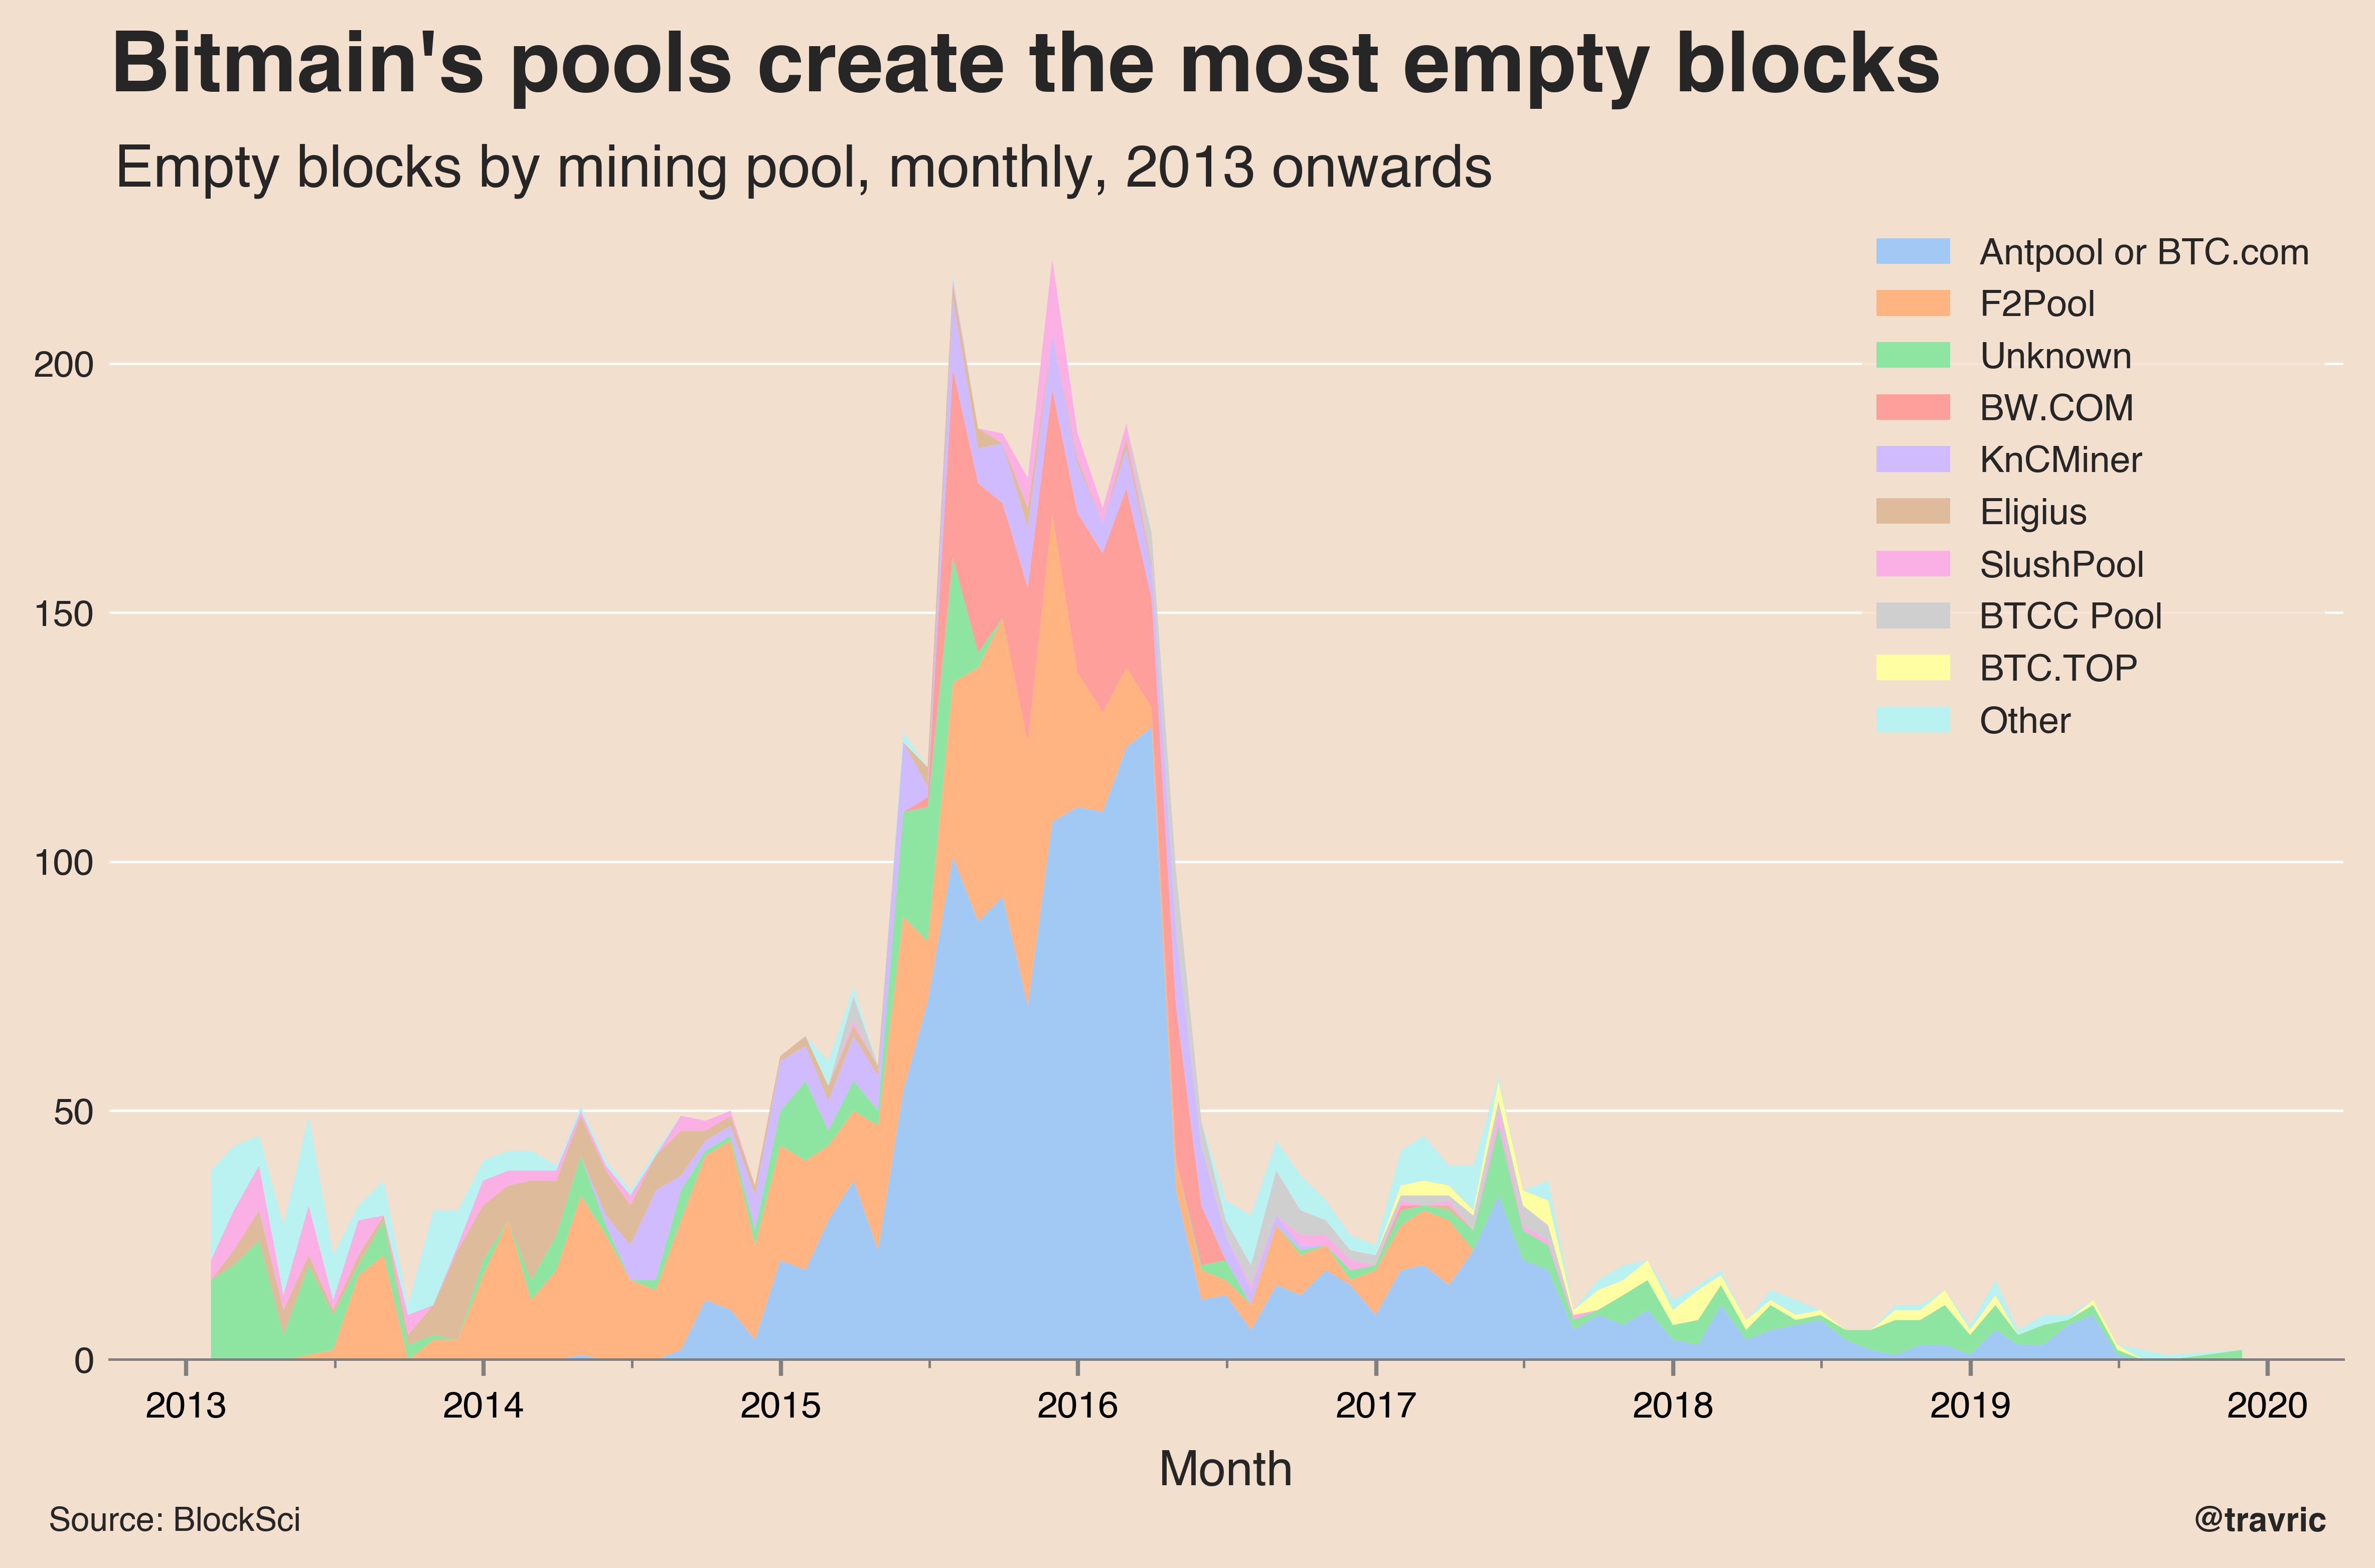

In [9]:
sns.set_palette("pastel")

# Creating my figure and setting up first sublot within the figure
fig, ax1 = plt.subplots()
plt.subplots_adjust(bottom=0.11, top=0.91)

# Creating my x,y and labels
x = df2.index
y = []
for i in df2.columns:
    y.append(df2[i])

# Plotting the line via OOP method
ax1.stackplot(x, y, labels=df2.columns)
ax1.set_xlabel("Month")
ax1.set_title("Bitmain's pools create the most empty blocks", loc="left")
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.legend(loc='upper right')
plt.suptitle("Empty blocks by mining pool, monthly, 2013 onwards", ha='left', va='bottom', x=0.082, y=0.913)
plt.setp(ax1.get_xticklabels(), color="black")

# Adding the caption at the bottom (which is its own subplot in the figure, appended below the first)
axbox = plt.axes([0.05, 0, 0.9, 0.02], yticklabels=[], xticklabels=[], xticks=[], frame_on=False)
axbox.grid(False)
axbox.add_artist(AnchoredText("@travric", frameon=False, loc="upper right", pad=0, prop=dict(fontsize="8", fontweight="bold")))
axbox.add_artist(AnchoredText("Source: BlockSci", frameon=False, loc="upper left", pad=0, prop=dict(fontsize="8")))
plt.show()

Lets investigate which mining pool contributed the most relative to their share of total blocks

In [10]:
df3 = chain.heights_to_dates(df_miners)
df3["time"]=df3.index

# grouping by month and miner
df3 = df3.groupby([pd.Grouper(key="time", freq="M"), pd.Grouper(key="miner")]).block_index.count().reset_index()

# Let's filter from 2013 onwards for relevancy
df3 = df3[df3.time>'2013']
df3 = df3.pivot(index="time", columns="miner", values="block_index").reset_index()

# Minimizing columns, first make a list of the long tail
sorted_miners_df = pd.DataFrame(df3.sum().sort_values(ascending=False)).reset_index()
list_miner_tail_all=[]
for i in sorted_miners_df.index:
    if sorted_miners_df.iloc[i]['miner'] not in list_miner_top:
        list_miner_tail_all.append(sorted_miners_df.iloc[i]["miner"])
list_miner_tail_all = list_miner_tail_all[2:]

# Sum the long tail and sum Bitmain's pools
df3["Other"]= df3[list_miner_tail_all].sum(axis=1)
df3["Antpool or BTC.com"] = df3[["AntPool","BTC.com"]].sum(axis=1)

# Now to avoid duplication, refine columns
df3 = df3[["time"]+list_miner_top].fillna(0)
df3 = df3.set_index(df3.time, drop=True).drop('time', axis=1)

# Create a new DataFrame to help calculate the prop from each pool
df4 = pd.DataFrame(df2.sum()).reset_index()
df4["total_blocks"] = pd.DataFrame(df3.sum()).reset_index()[0]
df4.columns =["miner", "empty_blocks", "total_blocks"]
df4["percent_empty"]=100*df4.empty_blocks/df4.total_blocks


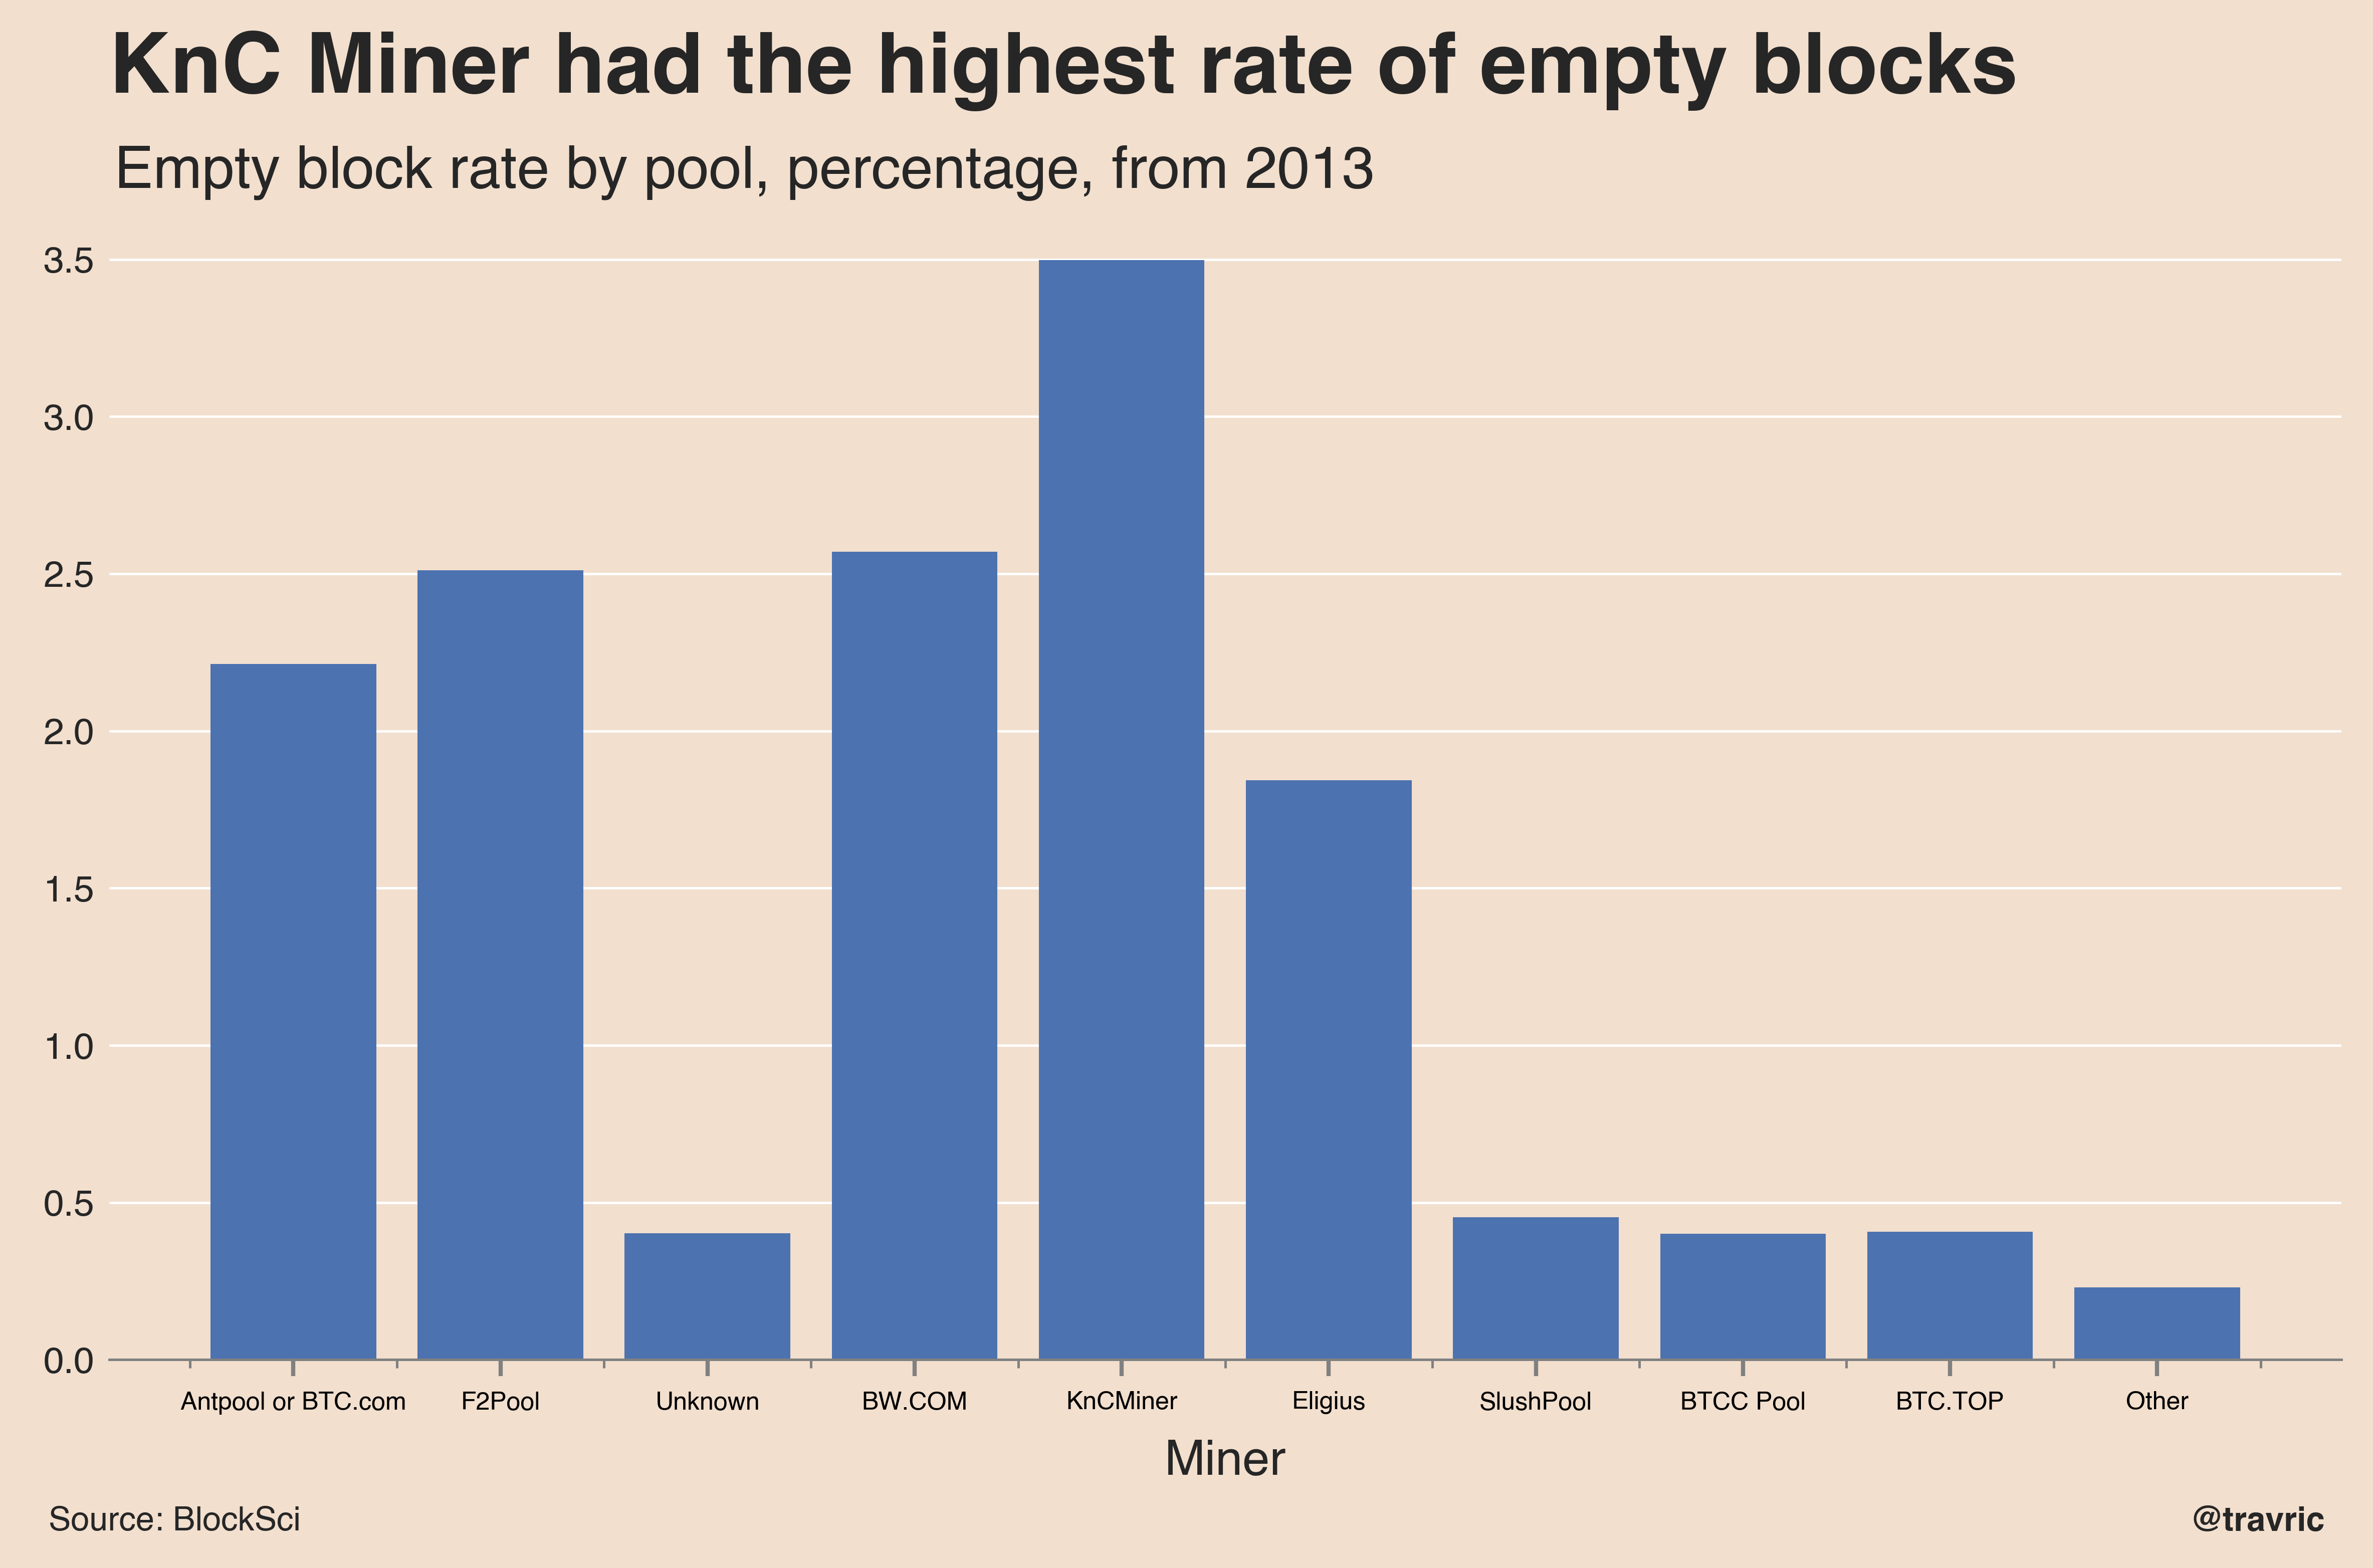

In [11]:
sns.set_palette("deep")
mpl.rc('xtick', labelsize=6)

# Creating my figure and setting up first sublot within the figure
fig, ax1 = plt.subplots()
plt.subplots_adjust(bottom=0.11, top=0.91)

# Plotting the line via OOP method
ax1.bar(x=df4.miner, height=df4.percent_empty)
ax1.set_xlabel("Miner")
ax1.set_title("KnC Miner had the highest rate of empty blocks", loc="left")
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
plt.suptitle("Empty block rate by pool, percentage, from 2013", ha='left', va='bottom', x=0.082, y=0.913)
plt.setp(ax1.get_xticklabels(), color="black")

# Adding the caption at the bottom (which is its own subplot in the figure, appended below the first)
axbox = plt.axes([0.05, 0, 0.9, 0.02], yticklabels=[], xticklabels=[], xticks=[], frame_on=False)
axbox.grid(False)
axbox.add_artist(AnchoredText("@travric", frameon=False, loc="upper right", pad=0, prop=dict(fontsize="8", fontweight="bold")))
axbox.add_artist(AnchoredText("Source: BlockSci", frameon=False, loc="upper left", pad=0, prop=dict(fontsize="8")))
plt.show()